In [13]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip list

In [14]:
# set up for destroying this evnironment😈

from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torch
import numpy as np

# Assuming that we are on a CUDA machine, this should print a CUDA device:

env = gym.make("ALE/Assault-v5").env

n_actions = env.action_space.n

print("n_actions=", n_actions)

# for curios people
# 0 NOOP
# 1 FIRE
# 2 UP
# 3 RIGHT
# 4 LEFT
# 5 RIGHTFIRE
# 6 LEFTFIRE
gym.version.VERSION

n_actions= 7


'0.21.0'

In [15]:
def visualize(agent, t_max=10000):
    # для просмотра что моделька делает в целом)
    env_show = gym.make("ALE/Assault-v5", render_mode="human").env
    
    state = env_show.reset()

    for t in range(t_max):
        env_show.render()
        
        #predict with agent
        
        action = np.random.choice(np.arange(n_actions))
        
        new_state, reward, done, truncated, _ = env_show.step(action)

        done = done or truncated

        state = new_state
        if done: 
            break
    
    
    env_show.close()

(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), {'lives': 4, 'episode_frame_number': 0, 'frame_number': 0})


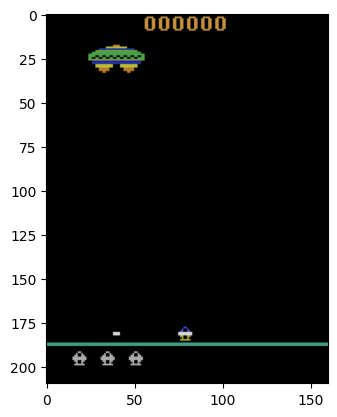

In [16]:
import matplotlib.pyplot as plt

state = env.reset() # state - здесь изображение
print(state)
state = state[0]

height, width, num_channels = state.shape

plt.imshow(state) # здесь можно убрать лишние пиксели, но пока пофиг

In [17]:
from functorch import vmap
import torchvision.transforms as transforms 

def get_img_as_tensor(state):
    transform = transforms.ToTensor()
    tensor = transform(state)
    return tensor

Архитектура Нейронной сети

In [18]:
import torch

import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, num_channels, height, width, n_actions):
        super(NeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=1, kernel_size=(8, 8), stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 8), stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 4), stride=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))

        self.fc_size = self.compute_fc_size(num_channels, height, width)

        self.fc1 = nn.Linear(self.fc_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, n_actions)
        
    def compute_fc_size(self, num_channels, height, width):
        # Применение сверточных и пулинг слоев для вычисления размера входа
        x = torch.rand(1, num_channels, height, width)
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        # Вычисление размера входа для полносвязанного слоя
        fc_size = x.view(1, -1).size(1)
        return fc_size
    
    
    def forward(self, x):

        x = self.pool(self.conv1(x)) # F.RELU???
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [19]:
from PIL import Image 


def build_model(num_channels, height, width, n_actions):
    model = NeuralNetwork(num_channels=num_channels, height=height, width=width, n_actions=n_actions)
    return model

model = build_model(num_channels, height, width, n_actions=n_actions)

print(model(get_img_as_tensor(state).unsqueeze(0)))

tensor([[ 0.1132, -0.0026,  0.0809,  0.0957,  0.1040, -0.2124, -0.2247]],
       grad_fn=<AddmmBackward0>)


## Функция ошибки!!!!

In [20]:
from IPython.display import clear_output
from tqdm import trange

def compute_td_loss(model, states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    # print(states)
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    next_states = torch.tensor(next_states, dtype=torch.float32) # shape: [batch_size, state_size]
    is_done = torch.tensor(is_done, dtype=torch.uint8)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = model(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]

    # compute q-values for all actions in next states
    predicted_next_qvalues = model(next_states).detach()

    # compute V*(next_states) using predicted next q-values
    # print(predicted_next_qvalues)
    next_state_values = torch.max(predicted_next_qvalues, 1)[0]
    # print(next_state_values)

    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = torch.where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

## get action

In [21]:
def get_action(model, state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = get_img_as_tensor(state).unsqueeze(0)
    q_values = model(state).detach().numpy()

    if np.random.rand() < epsilon:
        return np.random.choice(np.arange(0, n_actions))

    return int(np.argmax(q_values))

In [22]:
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

In [23]:
cnt = 0

def generate_session(env, t_max=1000, epsilon=0, train=False):
    global cnt
    cnt += 1
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    state = env.reset()[0]

    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    print((cnt - 1) % 10 + 1)

    for t in range(t_max):
        action = get_action(model, state, epsilon=epsilon)

        next_state, reward, done, truncated, _ = env.step(action)

        done = done or truncated
     
        if train:
            states.append(get_img_as_tensor(state))
            actions.append(action)
            rewards.append(reward)
            next_states.append(get_img_as_tensor(next_state))
            dones.append(done)
            # compute_td_loss(model, get_img_as_tensor(state).unsqueeze(0), [action], [reward], get_img_as_tensor(next_state).unsqueeze(0), [done]).backward()

            # opt.step()

        total_reward += reward
        state = next_state
        if done:
            break
    
    states = torch.stack(states, dim=0)
    next_states = torch.stack(next_states, dim=0)
    # print(torch.stack(states))
    
    opt.zero_grad()
    compute_td_loss(model, states, actions, rewards, next_states, dones).backward()
    opt.step() 
    
    return total_reward

Обучение нейронной сети.

epoch #8	mean reward = 207.900	epsilon = 0.461


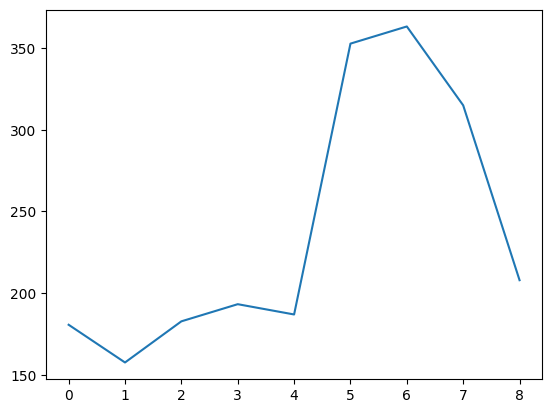

1


KeyboardInterrupt: 

In [24]:
epsilon = 0.5
from IPython.display import clear_output

import matplotlib.pyplot as plt

x = []
y = []

for i in range(1000):
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(10)]

    clear_output(True)
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))

    epsilon *= 0.99

    if epsilon < 0.001:
        epsilon = 0.1
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    x.append(i)
    y.append(np.mean(session_rewards))

    plt.plot(x, y)
    plt.show()